In [3]:
import pandas as pd
import numpy as np
from scipy import stats
import statistics as s

import matplotlib.pyplot as plt
import seaborn as sns
#import pylab 

In [4]:
from sklearn.impute import KNNImputer
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures, SplineTransformer
from sklearn.pipeline import make_pipeline

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import r2_score, mean_squared_error

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold

In [5]:
import warnings
warnings.filterwarnings("ignore") # suppress warning about function changing

In [19]:
df1 = pd.read_csv('./allfile_counts.csv', delimiter= '\t', header=0, index_col=0)

In [8]:
dpi = df1['dpi']

In [9]:
df = pd.read_csv('./normalized_counts2.txt', delimiter= '\t', header=0, index_col=0)

In [10]:
df = df.transpose()

In [11]:
df.index = df1.index

In [12]:
df['dpi'] = dpi

In [17]:
eg = df[['ENSSSCG00000000574', 'dpi']]

In [13]:
de = pd.read_csv('./deGenes2.txt', delimiter= '\t', header=0, index_col=0)
de.head()

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
ENSSSCG00000000002,98.064004,0.028840,0.005289,5.452589,4.964168e-08,7.248131e-07
ENSSSCG00000000007,358.054436,0.014851,0.006395,2.322250,2.021946e-02,5.024005e-02
ENSSSCG00000000010,22.894631,-0.045210,0.013462,-3.358360,7.840636e-04,3.331489e-03
ENSSSCG00000000015,7.852888,0.021296,0.010580,2.012802,4.413543e-02,9.545964e-02
ENSSSCG00000000019,789.126111,-0.020717,0.006906,-2.999841,2.701210e-03,9.376482e-03


In [14]:
len(de.index)

7605

In [15]:
logchange=0.13

In [16]:
len(de[de['log2FoldChange'].abs() > logchange]) 

20

In [17]:
df = df[de[de['log2FoldChange'].abs() > logchange].index.tolist()]
df.head()

,ENSSSCG00000000574,ENSSSCG00000000915,ENSSSCG00000002471,ENSSSCG00000002780,ENSSSCG00000003140,ENSSSCG00000003497,ENSSSCG00000006678,ENSSSCG00000007369,ENSSSCG00000009361,ENSSSCG00000010190,ENSSSCG00000010771,ENSSSCG00000011441,ENSSSCG00000013311,ENSSSCG00000015717,ENSSSCG00000016157,ENSSSCG00000022045,ENSSSCG00000024651,ENSSSCG00000025268,ENSSSCG00000025416,ENSSSCG00000026943
-5001,0.000000,47.883920,426.166890,208.295053,0.000000,0.000000,134.074977,0.0,11.970980,45.489724,2.394196,1.197098,3.591294,0.000000,2.394196,0.000000,10.773882,23.941960,2.394196,0.000000
-5001,0.000000,2.171336,1802.208972,113.995146,2.171336,1.085668,542.834028,0.0,2.171336,0.000000,1.085668,0.000000,3.257004,0.000000,1.085668,2.171336,19.542025,4.342672,0.000000,2.171336
-5001,0.815170,3.260678,315.470610,89.668649,3.260678,8.966865,236.399165,0.0,1.630339,0.000000,0.815170,0.000000,2.445509,4.891017,0.000000,1.630339,95.374836,4.891017,0.000000,1.630339
-5001,0.000000,2.874722,67.555958,310.469934,0.000000,1.437361,138.705318,0.0,1.437361,11.498886,0.718680,0.000000,0.000000,0.000000,0.718680,0.000000,41.683463,7.905484,7.905484,0.718680
-5002,3.983712,6.639520,2194.582532,20.803828,2.655808,0.885269,544.440604,0.0,4.426346,0.000000,0.000000,0.000000,7.967423,0.000000,0.000000,0.442635,37.623944,0.885269,2.213173,0.442635


In [18]:
df['dpi'] = dpi

In [26]:
mods = []

In [27]:
def imputer(df):
    # imputes by considering 10 closest neighbors, weighted by distance
    imputer = KNNImputer(n_neighbors=10, weights="distance")
    imputed_df = pd.DataFrame(imputer.fit_transform(df), index=df.index, columns=df.columns)
    imputed_df = pd.melt(imputed_df, value_vars=imputed_df.columns, var_name='day', value_name='ge')
    return(imputed_df)
    
def regress(df, gene, n):
    mod = make_pipeline(SplineTransformer(n_knots=5, degree=3), Ridge(alpha=0.2))
    x = df[['day']].values
    y = df['ge']
    mod.fit(x,y)
    
    mods.append(mod)
    
    lin = np.arange(0,29).reshape(-1, 1) 
    preds = mod.predict(lin)
    
    ax = plt.subplot(5, 6, n + 1)
    plt.scatter(df['day'], df[['ge']])
    plt.plot(lin, preds, color='red')
    plt.title(gene)

    
    



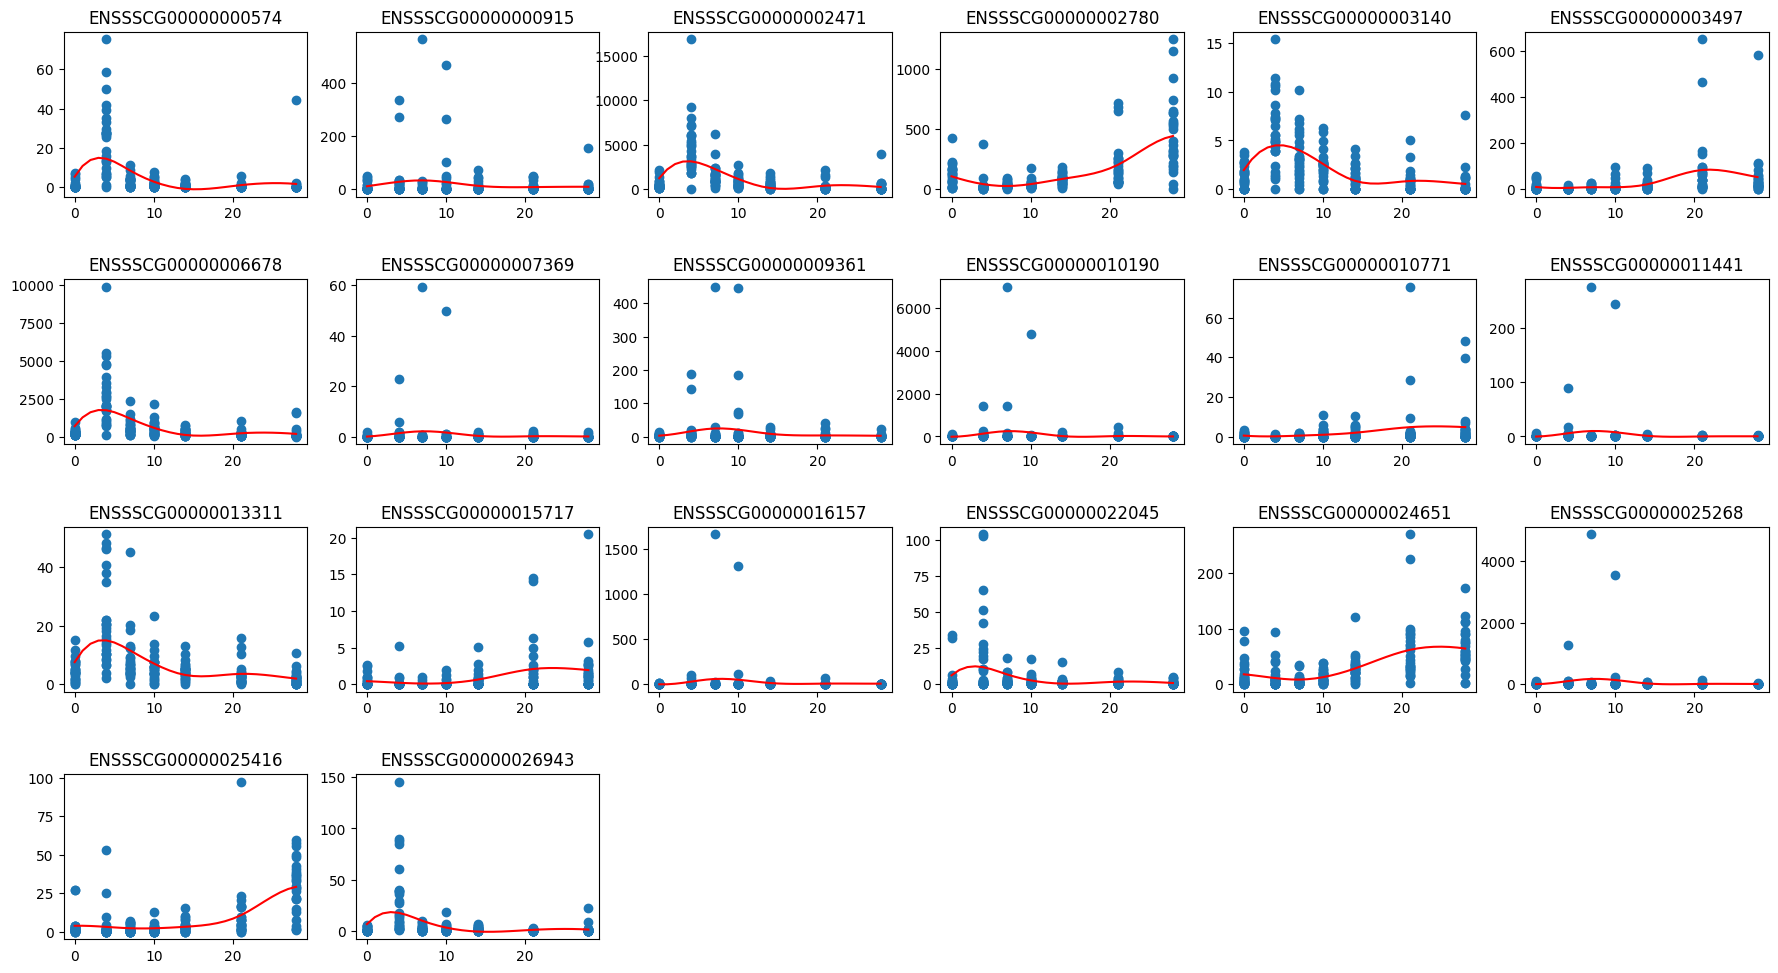

In [28]:
plt.figure(figsize=(22, 15))
plt.subplots_adjust(hspace=0.5)

for i, gene in enumerate(df.columns):
    
    if gene != 'dpi':

        gene_df = df[[gene, 'dpi']]
        gene_df = gene_df.reset_index()
        gene_df = gene_df.pivot(index='index', columns='dpi')[gene].reset_index(drop=True).drop(11, axis=1)

        gene_df_imputed = imputer(gene_df)

        regress(gene_df_imputed, gene, i)

In [29]:
patient = df.iloc[2,:]

In [30]:
patient

ENSSSCG00000000574      0.815170
ENSSSCG00000000915      3.260678
ENSSSCG00000002471    315.470610
ENSSSCG00000002780     89.668649
ENSSSCG00000003140      3.260678
ENSSSCG00000003497      8.966865
ENSSSCG00000006678    236.399165
ENSSSCG00000007369      0.000000
ENSSSCG00000009361      1.630339
ENSSSCG00000010190      0.000000
ENSSSCG00000010771      0.815170
ENSSSCG00000011441      0.000000
ENSSSCG00000013311      2.445509
ENSSSCG00000015717      4.891017
ENSSSCG00000016157      0.000000
ENSSSCG00000022045      1.630339
ENSSSCG00000024651     95.374836
ENSSSCG00000025268      4.891017
ENSSSCG00000025416      0.000000
ENSSSCG00000026943      1.630339
dpi                    21.000000
Name: -5001, dtype: float64

In [31]:
patient_dpi = patient.pop('dpi')

In [32]:
guesses = []

for gene in range(len(patient)):
    value = patient[gene]
    min_dif = 10000
    best_guess = 0
    counter = 0
    mod = mods[gene]
    lin = np.arange(0,29).reshape(-1, 1) 
    preds = mod.predict(lin)

    inv_dist = []


    for i, p in enumerate(preds):
        inv_dist.append(1/pow(value - p, 16))


    s = sum(inv_dist)
    weights = inv_dist/s

    est = round(sum(np.multiply(np.arange(0,29),weights)))
    guesses.append(est)

In [33]:
print(stats.mode(guesses).mode[0])

9


In [34]:
gene=0
value = patient[gene]
min_dif = 10000
best_guess = 0
counter = 0
mod = mods[gene]
lin = np.arange(0,29).reshape(-1, 1) 
preds = mod.predict(lin)

inv_dist = []

    
for i, p in enumerate(preds):
    inv_dist.append(1/pow(value - p, 16))

        
s = sum(inv_dist)
weights = inv_dist/s

est = round(sum(np.multiply(np.arange(0,29),weights)))

In [35]:
est

21

In [36]:
# INVERSE DISTANCE WEIGHTING

In [37]:
patient_dpi

21.0

In [38]:
def n_w_for_half(weights):
    weights.sort()
    weights = weights[::-1]
    tot=0
    for i in range(len(weights)):
        if tot >= 0.5:
            return(i)
        tot = tot+weights[i]



In [39]:
def individual_pred(patient):
    guesses = []


    for gene in range(len(patient)):
        value = patient[gene]
        mod = mods[gene]
        lin = np.arange(0,29).reshape(-1, 1) 
        preds = mod.predict(lin)

        dist = []
        inv_dist = []


        for i, p in enumerate(preds):
            dist.append(abs(value - p))                       
            
            inv_dist.append(1/pow(value - p,16))


        s = sum(inv_dist)
        weights = inv_dist/s

        est = sum(np.multiply(np.arange(0,29),weights))
        
        guesses.append(est)

    return(guesses)

In [40]:
all_preds = []
true_vals = []
for i in range(len(df.index)):
    patient = df.iloc[i,:]
    patient_dpi = patient.pop('dpi')
    pred = individual_pred(patient)
    all_preds.append(pred)
    true_vals.append(patient_dpi)

In [41]:
reg = LinearRegression().fit(all_preds, true_vals)

In [42]:
reg.intercept_

-4.109087982713065

In [43]:
reg.coef_

array([ 0.01396176, -0.11872546, -0.11956024,  0.11559135,  0.13111632,
        0.27404117, -0.05200569,  0.03040836,  0.05702987, -0.07625927,
        0.07356336,  0.00621022,  0.19514937,  0.01428409, -0.11307285,
        0.03288947,  0.23831627,  0.08122456,  0.25049632,  0.12378491])

In [44]:
def ensemble_pred(patient):
    guesses = []

    for gene in range(len(patient)):
        value = patient[gene]
        mod = mods[gene]
        lin = np.arange(0,29).reshape(-1, 1) 
        preds = mod.predict(lin)

        dist = []
        inv_dist = []


        for i, p in enumerate(preds):
            dist.append(abs(value - p))                       
            
            inv_dist.append(1/pow(value - p,16))


        s = sum(inv_dist)
        weights = inv_dist/s

        est = sum(np.multiply(np.arange(0,29),weights))
        
        guesses.append(est)

    pred = reg.intercept_ + sum(np.multiply(guesses,reg.coef_))

    return(pred)

In [45]:
ensemble_pred(patient)

5.282880363079878

In [46]:
diff = []
all_preds = []
true_vals = []
for i in range(len(df.index)):
    patient = df.iloc[i,:]
    patient_dpi = patient.pop('dpi')
    pred = ensemble_pred(patient)
    all_preds.append(pred)
    true_vals.append(patient_dpi)
    diff.append(abs(pred-patient_dpi))
#     print('pred')
#     print(pred)
#     print('actual')
#     print(patient_dpi)

In [47]:
np.average(diff)

4.312516945843503

In [48]:
r2_score(true_vals, all_preds)

0.558193770344054

In [49]:
mean_squared_error(true_vals, all_preds, squared=False)

5.925409288442956